In [23]:
import os
import pandas as pd
import numpy as np

from utils.file_utils import *
from common.network_analysis import *
import matplotlib.pyplot as plt

from scipy.stats import linregress

### 1. Build a bipartite network from raw data ###

In [2]:
# Load all congress member info.
global_congress_member_info = pd.read_csv('data/raw_data/all_congress_members.csv').drop(['Unnamed: 0'], axis=1)
print('Full congress member table shape is ' + str(global_congress_member_info.shape) + '.')

# Load followee info file name list for each congress member. 
following_table_names = os.listdir('data/raw_data/following_data_raw')
print(str(len(following_table_names)) + ' following tables loaded.')

following_table_list = []
valid_following_table_num = 0

for following_table_name in following_table_names:
    # Extract congress member name from file name.
    congress_member_name = '_'.join(following_table_name.split('_')[1:-1])
    
    # The followee info file is named by congress members' new twitter names, if they have ones.
    congress_member_info = global_congress_member_info[
    (global_congress_member_info['twitter_name'] == congress_member_name) |
    (global_congress_member_info['new_twitter_name'] == congress_member_name)
    ]
    
    # Ensure that the target congress member is unique in all congress member table.
    if congress_member_info.shape[0] != 1:
        print('Unable to locate the exact information of the congress member.')
        print(str(congress_member_info.shape[0]) + ' indexes found for name ' + congress_member_name + '.')
        continue
    
    following_table = pd.read_csv('data/raw_data/following_data_raw/' + following_table_name)
    
    # Merge all congress member info into followee info table.
    for column in congress_member_info.columns:
        following_table['cm_' + column] = congress_member_info[column].iloc[0]
        
    valid_following_table_num = valid_following_table_num + 1
    following_table_list.append(following_table)

'''
Get a following relationship table with all followees and congress members as well as all their info included, and save to csv.
[Unupdated twitter names have no impact on further analysis and calculations, just using old twitter names will be okay.]
[I want this global following table to be as raw as possible.]
'''
global_following_table = pd.concat(following_table_list)
global_following_table.loc[:, 'user_name'] = global_following_table['user_name'].str.lower()
global_following_table.loc[:, 'cm_twitter_name'] = global_following_table['cm_twitter_name'].str.lower()
global_following_table.loc[:, 'cm_new_twitter_name'] = global_following_table['cm_new_twitter_name'].str.lower()

save_to_csv('data/processed_data/', 'global_following_table.csv', global_following_table)

print(str(valid_following_table_num) + ' following tables are valid.')
print('The shape of the global following table is ' + str(global_following_table.shape) + '.')

Full congress member table shape is (183, 15).
164 following tables loaded.
164 following tables are valid.
The shape of the global following table is (308457, 32).


### 2. Extract information before 2015 ###

In [3]:
# Drop followees created after 2015 and save as csv.
global_following_table['created_at'] = pd.to_datetime(global_following_table['created_at'], format='%A %d %B %Y at %H:%M:%S', errors='coerce')

global_following_table_before2015 = global_following_table[global_following_table['created_at'].dt.year <= 2015]

save_to_csv('data/processed_data/', 'global_following_table_before2015.csv', global_following_table_before2015)

print(str(len(list(global_following_table_before2015['user_name'].unique()))) + ' unique followees in the bipartite following table before 2015.')
print('The length of bipartite following table before 2015 is ' + str(global_following_table_before2015.shape[0]) + '.')

156357 unique followees in the bipartite following table before 2015.
The length of bipartite following table before 2015 is 293623.


### 3. Extract key information from the global following table ###

In [4]:
# Eliminate inter-following relationships between congress members to get a bipartite following table of congress members and followees.
congress_member_list = list(global_following_table_before2015['cm_twitter_name'].unique()) + list(global_following_table_before2015['cm_new_twitter_name'].unique())
bipartite_table_before2015 = global_following_table_before2015[~global_following_table_before2015['user_name'].isin(congress_member_list)]

# Save bipartite following table to csv.
save_to_csv('data/processed_data/', 'bipartite_following_table_before2015.csv', bipartite_table_before2015)
print(str(len(list(bipartite_table_before2015['user_name'].unique()))) + ' unique followees in the bipartite following table before 2015.')
print(str(bipartite_table_before2015.shape[0]) + ' links.')

156200 unique followees in the bipartite following table before 2015.
285574 links.


### 4. Split to house and senate tables ###

In [5]:
# Extract senate following table existing before 2015.
senate_table_before2015 = bipartite_table_before2015[bipartite_table_before2015['cm_chamber'] == 'Senate']
save_to_csv('data/processed_data/', 'senate_bipartite_table_before2015.csv', senate_table_before2015)

print(str(len(list(senate_table_before2015['user_name'].unique()))) + ' unique followees in the senate bipartite following table before 2015.')
print(senate_table_before2015.shape)

# Extract house following table existing before 2015.
house_table_before2015 = bipartite_table_before2015[bipartite_table_before2015['cm_chamber'] == 'House']
save_to_csv('data/processed_data/', 'house_bipartite_table_before2015.csv', house_table_before2015)

print(str(len(list(house_table_before2015['user_name'].unique()))) + ' unique followees in the house bipartite following table before 2015.')
print(house_table_before2015.shape)

58729 unique followees in the senate bipartite following table before 2015.
(79837, 32)
116719 unique followees in the house bipartite following table before 2015.
(205737, 32)


### 5. Get edge lists for global, house and senate following table. ###

In [6]:
global_edge_list = bipartite_table_before2015[['user_name', 'cm_twitter_name']]
save_to_csv('data/processed_data/', 'global_edge_list.csv', global_edge_list)

senate_edge_list = senate_table_before2015[['user_name', 'cm_twitter_name']]
save_to_csv('data/processed_data/', 'senate_edge_list.csv.csv', senate_edge_list)

house_edge_list = house_table_before2015[['user_name', 'cm_twitter_name']]
save_to_csv('data/processed_data/', 'house_edge_list.csv', house_edge_list)

print(global_edge_list.head(5))

         user_name cm_twitter_name
1         housegop   chuckgrassley
2        senategop   chuckgrassley
3    ronnamcdaniel   chuckgrassley
4  govmikehuckabee   chuckgrassley
5     newtgingrich   chuckgrassley


### 6. Plot degree distribution ###

In [ ]:
global_edge_list = list(global_edge_list.itertuples(index = False, name = None))

k = 1 , 78.86%
k = 2 , 11.02%
k = 3 , 3.64%
k = 4 , 1.74%
k = 5 , 0.99%
k = 6 , 0.67%
k = 7 , 0.48%
k = 8 , 0.32%
k = 9 , 0.25%
k = 10 , 0.21%


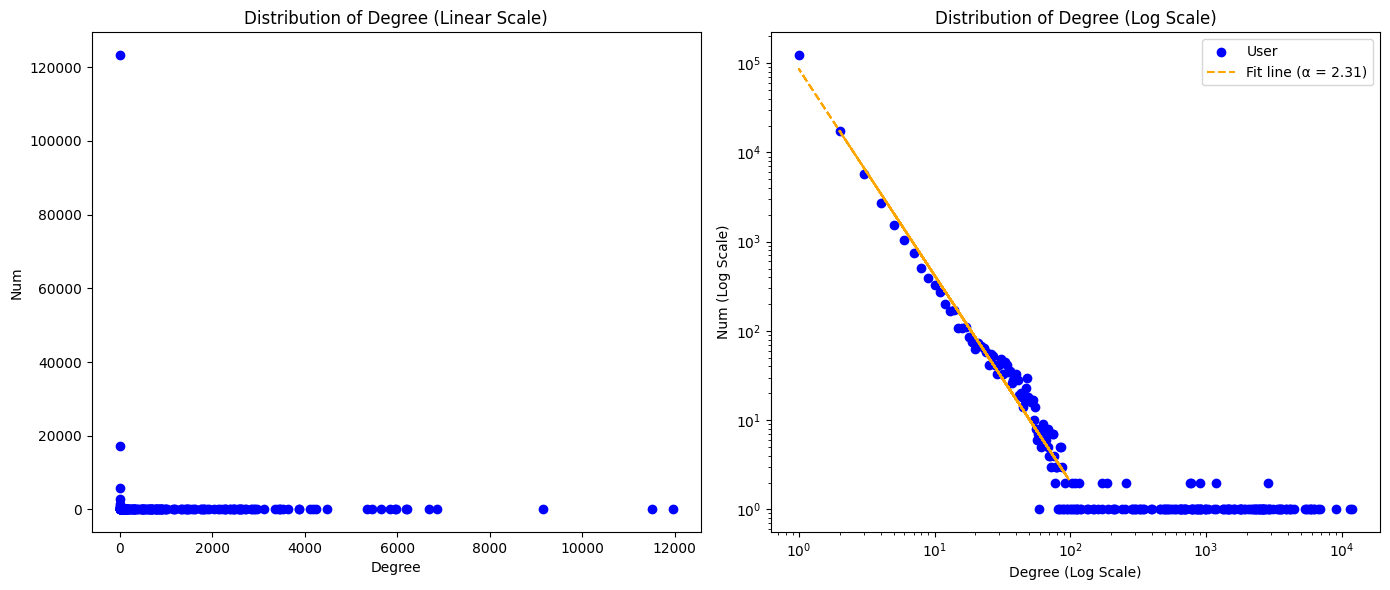

In [30]:
degree_to_num = {}

follower_degree, followee_degree = degree_calculation(global_edge_list)

for user, degree in follower_degree.items():
    if degree in degree_to_num:
        degree_to_num[degree] = degree_to_num[degree] + 1
    else:
        degree_to_num[degree] = 1

for user, degree in followee_degree.items():
    if degree in degree_to_num:
        degree_to_num[degree] = degree_to_num[degree] + 1
    else:
        degree_to_num[degree] = 1

for i in range(10):
    print(f'k = {i + 1} , {degree_to_num[i + 1] / 156364 * 100:.2f}%')

degree_list = [degree for degree in degree_to_num.keys()]
degree_num = [num for num in degree_to_num.values()]

# 过滤掉度数和计数为0的数据，避免在对数变换时出现问题
degree_list = np.array(degree_list)
degree_num = np.array(degree_num)
valid = (degree_list > 0) & (degree_num > 0)
degree_list = degree_list[valid]
degree_num = degree_num[valid]

# 对数据进行对数变换
log_degree = np.log10(degree_list)
log_num = np.log10(degree_num)

# 选择斜率部分的数据进行拟合 (假设度数在10到100之间）
lower_threshold = 0
upper_threshold = 100
selected = (degree_list > lower_threshold) & (degree_list < upper_threshold)
log_degree_selected = log_degree[selected]
log_num_selected = log_num[selected]

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(log_degree_selected, log_num_selected)
alpha = -slope

plt.figure(figsize=(14, 6))

# Linear scale
plt.subplot(1, 2, 1)
plt.scatter(degree_list, degree_num, color='blue', label='User')
plt.title("Distribution of Degree (Linear Scale)")
plt.xlabel("Degree")
plt.ylabel("Num")

# Log scale
plt.subplot(1, 2, 2)
plt.scatter(degree_list, degree_num, color='blue', label='User')
plt.xscale('log')
plt.yscale('log')
plt.title("Distribution of Degree (Log Scale)")
plt.xlabel("Degree (Log Scale)")
plt.ylabel("Num (Log Scale)")

fit_line = 10**(intercept + slope * np.log10(degree_list[selected]))  # 使用对数线性回归的结果绘制拟合线
plt.plot(degree_list[selected], fit_line, color='orange', linestyle='--', label=f'Fit line (α = {alpha:.2f})')

plt.legend()

plt.tight_layout()
plt.show()